In [2]:
import numpy as np
import sklearn
import pickle
import sys
from os.path import dirname
from os import getcwd
from sklearn.svm import SVC
import time
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from framework.pixelhop2 import PixelHopPP_Unit
from framework.util import get_gender_label, get_image_array, myStandardScaler, Generate_feature, MaxPooling
import cv2
from sklearn import preprocessing
from scipy.stats import entropy
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from numpy.random import RandomState
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings("ignore")

n1 =18
n2 = 13
n3 = 11
n_comp = 20
standardize = False
energy_th = 0.0005
num_of_train_pixelhop = 4000

foldnum = 1

def Generate_feature_single_img(x, n_comp, pca_list=[], hop=1, loc={'1': [[0, 0, 10 ,12],[0, 16, 10, 28], [7, 9, 18, 19], [17,5, 25, 23]],
                                    '2':[[0, 0, 4, 10], [6, 0, 10, 10], [0, 3, 10, 7]]}):
    # old '2':[[0, 0, 4, 10], [4, 1, 10, 9]]
    fea_in_loc = []
    lenn = len(pca_list)
    for i in range(len(loc[str(hop)])):
        l = loc[str(hop)][i]
        tmp_fea = []
        tmp_pca = []
        if lenn == 0:
            pca = PCA(n_components=n_comp)
            tmp = np.moveaxis(x[:, l[0]:l[2], l[1]:l[3], :].copy(), -1, 0)
            tmp = tmp.reshape(tmp.shape[0]*tmp.shape[1], -1)
            pca.fit(tmp)
            tmp_pca.append(pca)
        else:
            pca = pca_list[i][0]
        for k in range(x.shape[-1]):
            tmp = x[:, l[0]:l[2], l[1]:l[3], k].reshape(x.shape[0], -1)
            tmp = pca.transform(tmp)
            tmp_fea.append(tmp)
        fea_in_loc.append(np.concatenate(tmp_fea, axis=1))
        if lenn == 0:
            pca_list.append(tmp_pca)
    return fea_in_loc, pca_list

def feature_extraction(X_train, X_test):
    allpatches = np.concatenate((X_train, X_test),axis=0)
    S = [len(X_train), len(X_test)]
    
    saab, outtrainsaab1, kernel_filter, falttened = PixelHopPP_Unit(allpatches[0:num_of_train_pixelhop], num_kernels=n1, saab=None, window=5, stride=1, train=True, energy_th=energy_th, ch_decoupling=False, ch_energies=None, kernel_filter=[])
    #Apply saab transfrom to the training data
    _, out1, _, _ = PixelHopPP_Unit(allpatches, num_kernels=n1, saab=saab, window=5, stride=1, train=False, ch_decoupling=False, kernel_filter=kernel_filter)
    out1ave = MaxPooling(out1)
    print("       <INFO> Hop1 #Nodes: %s"%(out1.shape[-1]))
    saab, outtrainsaab2, kernel_filter, falttened = PixelHopPP_Unit(out1ave[0:num_of_train_pixelhop], num_kernels=n2, saab=None, window=5, stride=1, train=True, energy_th=energy_th, ch_decoupling=True, ch_energies=falttened, kernel_filter=[])
    _, out2, _, _ = PixelHopPP_Unit(out1ave, num_kernels=n2, saab=saab, window=5, stride=1, train=False, ch_decoupling=True, kernel_filter=kernel_filter)
    out2ave = MaxPooling(out2)
    print("       <INFO> Hop2 #Nodes: %s"%(out2.shape[-1]))
    saab, _, kernel_filter, falttened = PixelHopPP_Unit(out2ave[0:num_of_train_pixelhop], num_kernels=n3, saab=None, window=5, stride=1, train=True, energy_th=energy_th, ch_decoupling=True, ch_energies=falttened, kernel_filter=[])
    _, out3, _, _ = PixelHopPP_Unit(out2ave,num_kernels=n3,saab=saab,window=5,stride=1,train=False,ch_decoupling=True,kernel_filter=kernel_filter)
    print("       <INFO> Hop2 #Nodes: %s"%(out3.shape[-1]))

    out1_train, out1_test= out1[0:S[0]], out1[S[0]:S[1]+S[0]]
    out2_train, out2_test= out2[0:S[0]], out2[S[0]:S[1]+S[0]]
    out3_train, out3_test= out3[0:S[0]], out3[S[0]:S[1]+S[0]]

    
    out1_train, p = Generate_feature_single_img(out1_train, n_comp, pca_list=[], hop=1)
    out1_test, _ = Generate_feature_single_img(out1_test, n_comp, pca_list=p, hop=1)

    out2_train, p = Generate_feature_single_img(out2_train, n_comp, pca_list=[], hop=2)
    out2_test, _ = Generate_feature_single_img(out2_test, n_comp, pca_list=p, hop=2)

    out3_train = out3_train.reshape(out3_train.shape[0], -1)
    out3_test = out3_test.reshape(out3_test.shape[0], -1)  
    
    return [out1_train, out2_train, [out3_train]], [out1_test, out2_test, [out3_test]]

def LR(x_train, y_train, x_test, y_test):
    clf = LogisticRegression()
    clf.fit(x_train, y_train)
    print("     <INFO> train acc: %s"%(clf.score(x_train, y_train)))
    print("     <INFO> test acc: %s"%(clf.score(x_test, y_test)))
    return clf.predict_proba(x_train), clf.predict_proba(x_test)

def SVM(x_train, y_train, x_test, y_test):
    clf = SVC(gamma='auto', probability=True)
    clf.fit(x_train, y_train)
    print("     <INFO> train acc: %s"%(clf.score(x_train, y_train)))
    print("     <INFO> test acc: %s"%(clf.score(x_test, y_test)))
    return clf.predict_proba(x_train), clf.predict_proba(x_test)
    
def Hop3_classification(train_val_feature_list, test_feature_list, train_val_labels, test_labels):
    Hop3_train_val_feature = train_val_feature_list[-1]
    Hop3_test_feature = test_feature_list[-1]
    clf_SVM = SVC(gamma='auto', probability=True).fit(Hop3_train_val_feature, train_val_labels)
    print('Train acc:', clf_SVM.score(Hop3_train_val_feature, train_val_labels))
    print('Test acc:', clf_SVM.score(Hop3_test_feature, test_labels), '\n')

In [3]:
def flip_aug(x):
    new_x = []
    for i in range(len(x)):
        new_x.append(cv2.flip(x[i], 1).reshape(x.shape[1], x.shape[2], -1))
    return np.array(new_x)

def cwPCA(x, eng_percent):
    pca = PCA(n_components=500)
    x = pca.fit_transform(x)
    ratio = np.cumsum(pca.explained_variance_ratio_) >= eng_percent
    n_comp = np.argmax(ratio)
    #print(n_comp, " compontents retained!")
    x = x[:, :n_comp]
    dis = euclidean_distances(x, x)+1000*np.eye(len(x))
    return dis

def pca_aug(x, eng_percent=0.9):
    xx = x.copy()
    x = x.reshape(x.shape[0], -1, 3)/255
    dis0 = cwPCA(x[:,:,0], eng_percent)
    dis1 = cwPCA(x[:,:,1], eng_percent)
    dis2 = cwPCA(x[:,:,2], eng_percent)
    idx = np.argmin(dis0+dis1+dis2, axis=1)
    new_x = []
    ct = 1
    for i in range(len(xx)):
        tmp = xx[i]/2 + xx[idx[i]] / 2
        new_x.append(tmp)
        if ct > 0:
            plt.imshow(tmp[:,:])
            plt.title('mean')
            plt.show()
            plt.imshow(xx[i,:,:])
            plt.title('raw')
            plt.show()
            ct -= 1
    return np.array(new_x).reshape(xx.shape[0], xx.shape[1], xx.shape[2], -1)

def data_aug(xf):
    x1 = flip_aug(xf)
    print(x1.shape)
    x2 = pca_aug(xf)
    print(x2.shape)
    xf = np.concatenate((xf, x1, x2), axis=0)
    print('after aug', xf.shape)
    return xf

(10488, 32, 32, 3) (10488,)
(2357, 32, 32, 3)


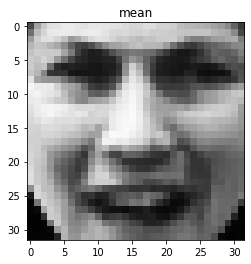

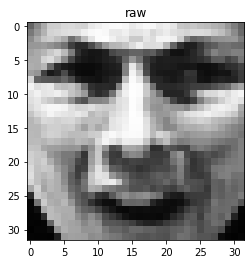

(2357, 32, 32, 3)
after aug (7071, 32, 32, 3)
(17559, 32, 32, 3) (17559,)
       <INFO> Hop1 #Nodes: 18
xxx 13
xxx 13
xxx 13
xxx 13
xxx 13
xxx 9
xxx 9
xxx 13
xxx 13
xxx 4
xxx 3
xxx 1
xxx 3
xxx 1
xxx 1
xxx 0
xxx 0
xxx 0
       <INFO> Hop2 #Nodes: 122
xxx 11
xxx 11
xxx 11
xxx 11
xxx 7
xxx 11
xxx 5
xxx 6
xxx 3
xxx 3
xxx 0
xxx 0
xxx 0
xxx 8
xxx 11
xxx 9
xxx 7
xxx 7
xxx 7
xxx 4
xxx 4
xxx 2
xxx 1
xxx 1
xxx 1
xxx 0
xxx 5
xxx 8
xxx 7
xxx 4
xxx 5
xxx 3
xxx 1
xxx 1
xxx 1
xxx 1
xxx 0
xxx 0
xxx 0
xxx 2
xxx 5
xxx 4
xxx 5
xxx 5
xxx 1
xxx 1
xxx 0
xxx 0
xxx 0
xxx 0
xxx 0
xxx 0
xxx 1
xxx 3
xxx 3
xxx 2
xxx 2
xxx 1
xxx 0
xxx 0
xxx 0
xxx 0
xxx 0
xxx 0
xxx 0
xxx 1
xxx 3
xxx 3
xxx 2
xxx 0
xxx 0
xxx 0
xxx 0
xxx 0
xxx 2
xxx 2
xxx 2
xxx 0
xxx 0
xxx 0
xxx 0
xxx 0
xxx 0
xxx 1
xxx 0
xxx 0
xxx 0
xxx 0
xxx 0
xxx 0
xxx 0
xxx 0
xxx 0
xxx 0
xxx 0
xxx 0
xxx 0
xxx 0
xxx 0
xxx 0
xxx 0
xxx 0
xxx 0
xxx 0
xxx 0
xxx 0
xxx 0
xxx 0
xxx 0
xxx 0
xxx 0
xxx 0
xxx 0
xxx 1
xxx 0
xxx 0
xxx 0
xxx 0
xxx 0
xxx 0
xxx 0
xxx 0
       <INFO

In [4]:
folder_path = dirname(getcwd())
lfwlabels = get_gender_label(folder_path)
lfw_raw = get_image_array(folder_path)
train_images, test_images, y, yt = train_test_split(lfw_raw, lfwlabels, test_size=0.2, stratify=lfwlabels)
print(train_images.shape, y.shape)

x_aug = data_aug(train_images[y==0])
train_images = np.concatenate((train_images, x_aug), axis=0)
y = np.concatenate((y, np.zeros(len(x_aug))), axis=0)
print(train_images.shape, y.shape)
x, xt = feature_extraction(train_images, test_images)


In [5]:
px, pxt = [], []
for i in range(len(x)):
    for j in range(len(x[i])):
        a, b = LR(x[i][j], y, xt[i][j], yt)
        px.append(a)
        pxt.append(b)
    print()
print('\n ensemble')
px = np.concatenate(px, axis=1)
pxt = np.concatenate(pxt, axis=1)
print('')
a, b = LR(px, y, pxt, yt)

     <INFO> train acc: 0.8769292100916909
     <INFO> test acc: 0.8734273732367518
     <INFO> train acc: 0.879719801811037
     <INFO> test acc: 0.8597026305756768
     <INFO> train acc: 0.8543766729312603
     <INFO> test acc: 0.8349218452154022
     <INFO> train acc: 0.8410501737000968
     <INFO> test acc: 0.8452154022112085

     <INFO> train acc: 0.9595648954951876
     <INFO> test acc: 0.92527640106748
     <INFO> train acc: 0.9345634717239023
     <INFO> test acc: 0.8985894014487228
     <INFO> train acc: 0.9539837120564952
     <INFO> test acc: 0.931757529546321

     <INFO> train acc: 0.9242553676177458
     <INFO> test acc: 0.9134578726648875


 ensemble

     <INFO> train acc: 0.9709550657782334
     <INFO> test acc: 0.949675943576058


In [6]:
print('LR all')
a, b = LR(px[:,:], y, pxt[:,:], yt)
print('LR hop2+hop3')
a, b = LR(px[:,8:], y, pxt[:,8:], yt)
print('SVM all')
a, b = SVM(px[:,:], y, pxt[:,:], yt)
print('SVM hop2+hop3')
a, b = SVM(px[:,8:], y, pxt[:,8:], yt)

LR all
     <INFO> train acc: 0.9709550657782334
     <INFO> test acc: 0.949675943576058
LR hop2+hop3
     <INFO> train acc: 0.9712967708867247
     <INFO> test acc: 0.949675943576058
SVM all
     <INFO> train acc: 0.9709550657782334
     <INFO> test acc: 0.9492947007243614
SVM hop2+hop3
     <INFO> train acc: 0.9707842132239877
     <INFO> test acc: 0.9473884864658788


In [7]:
with open('/mnt/yifan/face_gender_fea_LFW.pkl', 'wb') as f:
    #d = pickle.load(f)
    pickle.dump({'x':x, 'xt':xt, 'y':y, 'yt':y, 'px':px, 'pxt':pxt},f)